In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import sklearn as sk
import urllib.request
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

sns.set(rc={'figure.figsize':(11.7,8.27)}) 
sns.set_style("whitegrid",  {'axes.linewidth': 2, 'axes.edgecolor':'black'})

#current commit doesn't have it in a raw csv file
source_url = 'https://raw.githubusercontent.com/allisonhorst/palmerpenguins/1a19e36ba583887a4630b1f821e3a53d5a4ffb76/data-raw/penguins_raw.csv'
penguins =  pd.read_csv(source_url)

description_url = 'https://raw.githubusercontent.com/allisonhorst/palmerpenguins/master/DESCRIPTION'
for line in urllib.request.urlopen(description_url):
    print(line.decode('utf-8')) 

Package: palmerpenguins

Title: Palmer Archipelago (Antarctica) Penguin Data 

Version: 0.1.0

Date: 2020-07-11

Authors@R: c(

    person(given = "Allison",

           family = "Horst",

           role = c("aut", "cre"),

           email = "ahorst@ucsb.edu",

           comment = c(ORCID = "0000-0002-6047-5564")),

    person(given = "Alison",

           family = "Hill",

           role = c("aut"),

           email = "apresstats@gmail.com",

           comment = c(ORCID = "0000-0002-8082-1890")),

    person(given = "Kristen",

           family = "Gorman",

           role = c("aut"),

           email = "kbgorman@alaska.edu",

           comment = c(ORCID = "0000-0002-0258-9264"))

           )

Description: Size measurements, clutch observations, and blood isotope ratios for adult foraging Adélie, Chinstrap, and Gentoo penguins observed on islands in the Palmer Archipelago near Palmer Station, Antarctica. Data were collected and made available by Dr. Kristen Gorman and the Pa

In [2]:
def clean_penguins(penguin_df, 
    cols = ['Species', 
            'Region', 
            'Island', 
            'Culmen Length (mm)', 
            'Culmen Depth (mm)', 
            'Flipper Length (mm)', 
            'Body Mass (g)', 
            'Sex']):
    penguin_tidy = penguin_df[cols]
    penguin_tidy = penguin_tidy.dropna() 
    return penguin_tidy
    
penguins = clean_penguins(penguins)
penguins.sample(20)

,Species,Region,Island,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex
18,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,34.4,18.4,184.0,3325.0,FEMALE
43,Adelie Penguin (Pygoscelis adeliae),Anvers,Dream,44.1,19.7,196.0,4400.0,MALE
335,Chinstrap penguin (Pygoscelis antarctica),Anvers,Dream,45.6,19.4,194.0,3525.0,FEMALE
211,Gentoo penguin (Pygoscelis papua),Anvers,Biscoe,50.4,15.3,224.0,5550.0,MALE
161,Gentoo penguin (Pygoscelis papua),Anvers,Biscoe,46.8,15.4,215.0,5150.0,MALE
252,Gentoo penguin (Pygoscelis papua),Anvers,Biscoe,48.5,15.0,219.0,4850.0,FEMALE
239,Gentoo penguin (Pygoscelis papua),Anvers,Biscoe,51.3,14.2,218.0,5300.0,MALE
49,Adelie Penguin (Pygoscelis adeliae),Anvers,Dream,42.3,21.2,191.0,4150.0,MALE
39,Adelie Penguin (Pygoscelis adeliae),Anvers,Dream,39.8,19.1,184.0,4650.0,MALE
53,Adelie Penguin (Pygoscelis adeliae),Anvers,Biscoe,42.0,19.5,200.0,4050.0,MALE


### prepping the dataset into "tidy" form

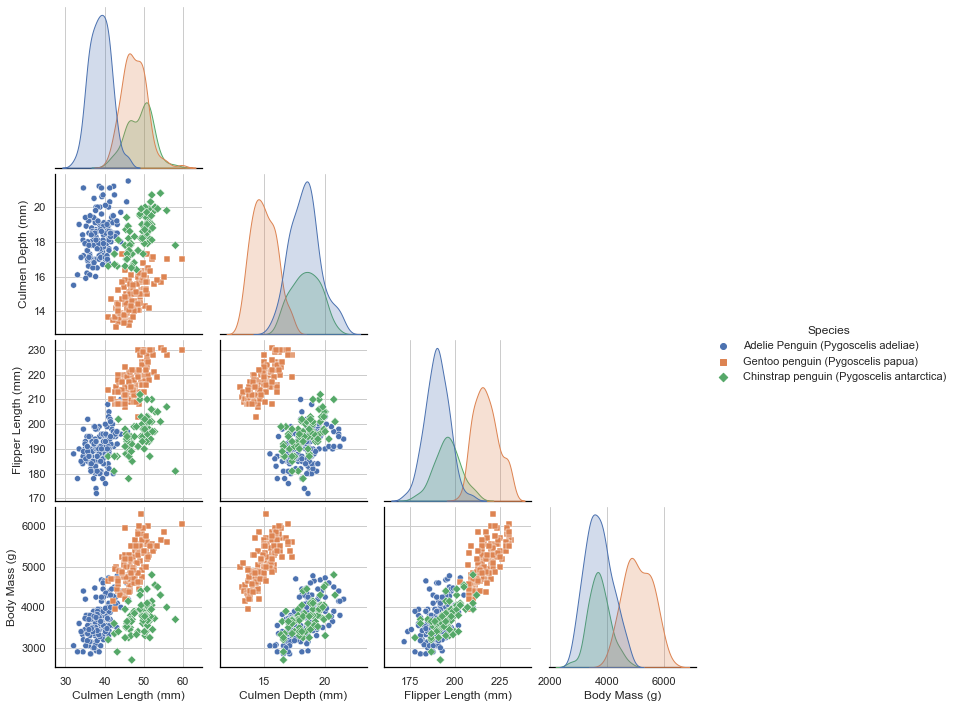

In [3]:
sns.pairplot(data=penguins, hue='Species', markers=["o", "s", "D"], corner=True)
plt.show() 

### PCA and LDA on penguins, for the curious

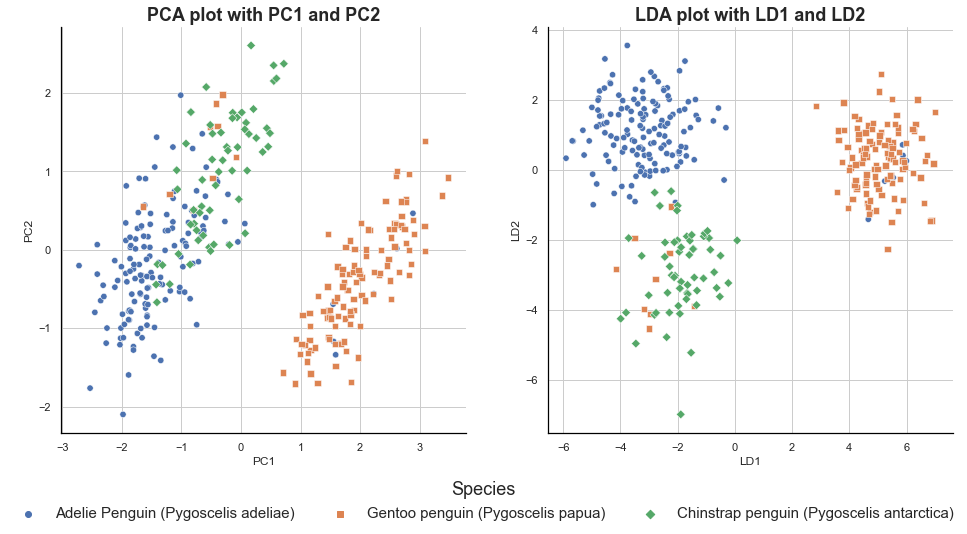

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

def PerformPCA(X):
    """
    Uses sklearn PCA tool to perform PCA
    input:
    X: Pandas Dataframe or Numpy Array of features
    
    output:
    X_pca: Pandas dataframe with column titles of PC1,...,PCn
    pca: sklearn's PCA object
    """
    X_standardized = StandardScaler().fit_transform(X)
    pca = PCA()
    pca.fit(X_standardized)
    X_pca_array = pca.transform(X_standardized)
    column_names = ['PC{}'.format(i+1) for i in range(X_pca_array.shape[1])] 
    X_pca = pd.DataFrame(X_pca_array, columns=column_names)
    return X_pca, pca


def PerformLDA(X, y):
    """
    Uses sklearn LinearDiscriminantAnalysis tool to perform LDA
    input:
    X: Pandas Dataframe or Numpy Array of features
    y: Pandas Series or Numpy Vector of target 
    
    output:
    X_lda: Pandas dataframe with column titles of LD1,...,LDn
    lda: sklearn's LinearDiscriminantAnalysis object
    """
    X_standardized = StandardScaler().fit_transform(X)
    lda = LinearDiscriminantAnalysis()
    lda.fit(X_standardized,y)
    X_lda_array = lda.transform(X_standardized)
    column_names = ['LD{}'.format(i+1) for i in range(X_lda_array.shape[1])] 
    X_lda = pd.DataFrame(X_lda_array, columns=column_names)
    return X_lda, lda


def makeplots(df, feature_col, response_col):
    """
    Makes PCA and LDA plots using functions: PerformPCA and PerformLDA
    input:
    df: data dataframe
    feature_col: list of strings to use as features in df
    response_col: string of response column in df
    
    output:
    None
    """
    features = df[feature_col]
    response = df[response_col]
    pca_features, pca_results = PerformPCA(features)
    pca_plotting = pca_features.join(response)
    lda_features, lda_results = PerformLDA(features, response)
    lda_plotting = lda_features.join(response)
    
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))

    g1 = sns.scatterplot(data=pca_plotting, x='PC1', y='PC2', hue='Species',
                         style='Species', markers=["o", "s", "D"], ax=ax[0],  legend=False,  s=40)
    sns.despine()
    ax[0].set_title('PCA plot with PC1 and PC2', fontsize=18, fontweight='bold')    
    g2 = sns.scatterplot(data=lda_plotting, x='LD1', y='LD2', hue='Species', 
                         style='Species', markers=["o", "s", "D"], ax=ax[1], legend=True,  s=40)
    sns.despine()
    g2.legend(fontsize = 15, 
              title="Species", 
              title_fontsize = 18, 
              loc='lower left', bbox_to_anchor=(-1.35, -.25),
              facecolor = 'white', ncol=3, frameon=False)
    ax[0].set_box_aspect(1)
    ax[1].set_box_aspect(1)
    ax[1].set_title('LDA plot with LD1 and LD2', fontsize=18, fontweight='bold')
    plt.show()
    

makeplots(penguins, ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)', 'Body Mass (g)'], 'Species')

In [5]:
from sklearn import linear_model

feature_cols = ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)']
response_col = 'Body Mass (g)'


def linear_regression(df, feature_cols, response_col, standardized = True):
    """
    Use linear_model to run a linear regression using sklearn
    
    """
    X = df[feature_cols]
    y = df[response_col]
    if standardized:
        X = StandardScaler().fit_transform(X)
        y = StandardScaler().fit_transform(y.values.reshape(-1, 1))
    regression = linear_model.LinearRegression() 
    regression.fit(X,y)
    
    try:
        print('Intercept of MLR model is {0:0.2f}'.format(regression.intercept_))
    except TypeError:
        print('Intercept of MLR model is {0:0.2f}'.format(regression.intercept_[0]))
    print('Regression Coefficients: ')
    for feature, coef in zip(feature_cols, regression.coef_.flatten()):
        print(f'{feature} ~ {coef:.2f}')
    return regression.predict(X)

print(' Normalized: ')
y_pred_norm = linear_regression(penguins, feature_cols, response_col)

print('\n Not Normalized: ')
y_pred = linear_regression(penguins, feature_cols, response_col, standardized=False)


 Normalized: 
Intercept of MLR model is -0.00
Regression Coefficients: 
Culmen Length (mm) ~ 0.02
Culmen Depth (mm) ~ 0.04
Flipper Length (mm) ~ 0.88

 Not Normalized: 
Intercept of MLR model is -6438.48
Regression Coefficients: 
Culmen Length (mm) ~ 3.37
Culmen Depth (mm) ~ 17.81
Flipper Length (mm) ~ 50.71


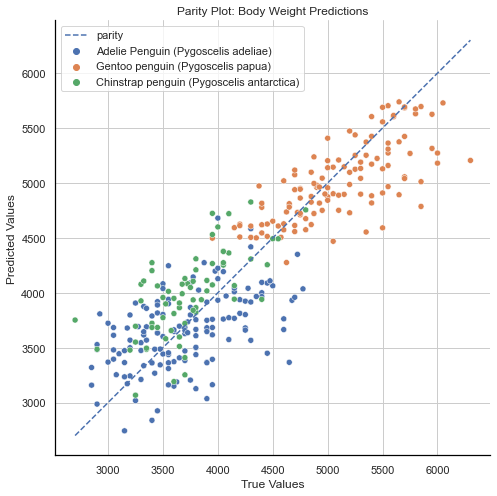

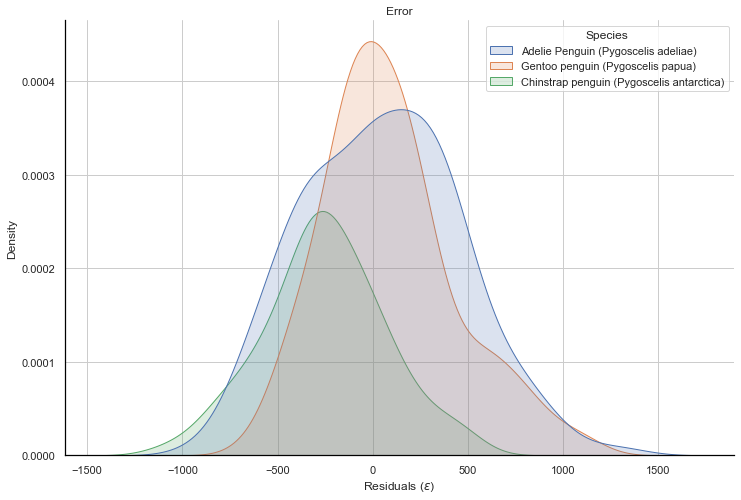

In [15]:
def error_distribution(true, pred, hue=None):
    ax = plt.subplots(figsize=(12, 8))
    error = true-pred
    if hue is not None: 
        sns.kdeplot(error, hue=hue, shade=True, alpha=.2)
    else:
        sns.kdeplot(error, shade=True, alpha=.2)
    sns.despine()

    plt.xlabel(r'Residuals ($\epsilon$)')
    plt.title('Error')
    plt.show()
    
def parity_plot(true, pred, title='', hue=None):
    """
    plot true vs the predicted data
    inputs: 2 list-like (arrays) data structures
    """
    fig, ax = plt.subplots(1,1,figsize=(10, 8))
    if hue is not None:
        sns.scatterplot(true, pred, hue=hue)
    else: 
        sns.scatterplot(true, pred)
    min_value = min(min(true), min(pred))
    max_value = max(max(true), max(pred))
    plt.plot([min_value, max_value],[min_value, max_value], '--', label="parity")
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    ax.set_box_aspect(1)
    sns.despine()
    plt.title('Parity Plot: {}'.format(title))
    plt.legend(loc='best')
    plt.show()
    
    error_distribution(true, pred, hue)

y = penguins[response_col]
parity_plot(y.values, y_pred, title='Body Weight Predictions', hue=penguins['Species'])

In [25]:
penguins.Species.value_counts()

Adelie Penguin (Pygoscelis adeliae)          146
Gentoo penguin (Pygoscelis papua)            120
Chinstrap penguin (Pygoscelis antarctica)     68
Name: Species, dtype: int64